In [1]:
%load_ext autoreload
%pylab inline
%autoreload 2

import seaborn as sns
import pandas as pd
import numpy as np
import sys

sys.path.append('..')

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow as tf
from tuning_manifold.fnp_model import Predictor
from tuning_manifold.synthetic_sampler import dataset_sampler, kernel_generator
from tuning_manifold.util import negloglik, pearson

tfk = tf.keras

# construct a model with architecture matching the saved file
neurons = 16
stimuli = 1024
cell_latent_dim = 64
training_data, validation_data, image_shape = dataset_sampler(neurons=neurons, n_stimuli=stimuli, dim_rf=8, image_shape=(32,32,1))
validation_data = validation_data.batch(1)

architecture = [[11,32],[5,8],[3,8],[3,8],[3,8],64,'same','batch']

inputs = [tfk.Input([stimuli, neurons], name='responses'), tfk.Input([stimuli, *image_shape], name='stimuli')]
predictor = Predictor(cell_latent_dim=cell_latent_dim, architecture=architecture, cummulative=True, contrastive_weight=0, l2_weight=0)

model = tfk.Model(inputs, predictor(inputs))
model.compile(loss=negloglik, metrics=[pearson, 'mse'], optimizer=tf.optimizers.Adam(learning_rate=1e-3, clipnorm=10))
model.load_weights('fnp_simulation_weights')

Architecture: [[11, 32], [5, 8], [3, 8], [3, 8], [3, 8], 64, 'same', 'batch']
Channel depth: 64
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [3]:
# Can use the version of these in the predictor to use samples from
# distribution, or these to sample the mean (when testing)

import tensorflow as tf
import tensorflow_probability as tfp
from tuning_manifold.fnp_model import DeepSetSimple, HigherRankOperator, image_to_distribution
from tuning_manifold.util import interpolate_bilinear

tfk = tf.keras
tfpl = tfp.layers

predictor = model.layers[2]

location_predictor = predictor.location_predictor

# draw samples from the distribution and move them from the batch dimension
heatmap_to_dist_mean = tf.keras.layers.Lambda(lambda x: tf.expand_dims(image_to_distribution(x).mean(), axis=1))

mean_location_predictor = tfk.Sequential([
    # Perform convolution on each g-response image and output flattend version
    location_predictor.layers[0],
    # Exclusive set collapse
    DeepSetSimple(True),
    # Take the collapsed image and convert to distribution
    HigherRankOperator(heatmap_to_dist_mean)
], name='mean_location_predictor')

feature_mlp = predictor.feature_mlp
feature_mlp.layers[5] = tfpl.MultivariateNormalTriL(cell_latent_dim, convert_to_tensor_fn=lambda x: x.mean())

def compute_summary(predictor, inputs, return_im_feat=False, samples=1):
    responses, stimuli = inputs

    # convolve input stimuli
    g = predictor.im_conv_wrapper(stimuli)
    gr = predictor.crc([responses, g])

    mean_locations = mean_location_predictor(gr)

    # extract the image feature for each trial x neuron estimate of the location
    bs, stimuli, Ny, Nx, Nc = g.shape
    bs, stimuli, neurons, samples, coordinates = mean_locations.shape
    tf.assert_equal(coordinates, 2)
    im_feat = interpolate_bilinear(tf.reshape(g, [-1, Ny, Nx, Nc]),
                                   tf.reshape(mean_locations, [-1, neurons * samples, 2]))
    im_feat = tf.reshape(im_feat, [-1, stimuli, neurons, samples, Nc])

    # construct vector for each trial that includes information about the responses
    # and the feature, including a STA type response
    response_samples = tf.tile(responses[:, :, :, None, None], [1, 1, 1, samples, 1])
    x2 = tf.concat([im_feat, im_feat * response_samples, response_samples], axis=-1)

    # then let those interact through an MLP and then compute an average feature.
    # again for trial N this is computed only using information from the other
    # trials. This should compute a summary statistics describing a neuron (other
    # than the spatial location) based on those other trials.
    cell_summary = feature_mlp(x2)

    if not return_im_feat:
        return mean_locations, cell_summary
    else:
        return mean_locations, cell_summary, im_feat

# Look at accuracy of RF location

In [4]:
import tensorflow as tf
import tensorflow_probability as tfp
import itertools

from tuning_manifold.fnp_model import image_to_distribution, image_to_gaussian, HigherRankOperator
from tuning_manifold.util import interpolate_bilinear

tfk = tf.keras
tfkl = tfk.layers
tfpl = tfp.layers

predictor = model.layers[2]

locations = []
all_params = []

for sample in itertools.islice(validation_data, 100):
    inputs, outputs = sample
    responses, stimuli, params, mean_response = inputs

    mean_location, cell_summary = compute_summary(predictor, (responses, stimuli))
        
    locations.append(mean_location[0])
    all_params.append(params[0])

locations = np.concatenate(locations, axis=1)
all_params = np.concatenate(all_params, axis=0)

/home/jcotton/anaconda3/envs/tensorflow2.2/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Text(0, 0.5, 'Pearson R for location')

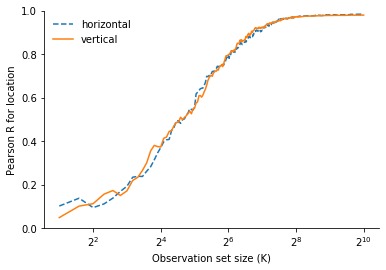

In [5]:
import scipy.stats
r_ys = [scipy.stats.pearsonr(all_params[:, 2], locations[i, :, 0, 0])[0] for i in range(1024)]
r_xs = [scipy.stats.pearsonr(all_params[:, 1], locations[i, :, 0, 1])[0] for i in range(1024)]

k = np.arange(len(r_xs))

plt.semilogx(k[2:], r_xs[2:], basex=2, linestyle='--', label='horizontal')
plt.plot(k[2:], r_ys[2:], label='vertical')

plt.legend(frameon=False)
plt.ylim(0, 1)
sns.despine(trim=False)

plt.xlabel('Observation set size (K)')
plt.ylabel('Pearson R for location')

# Recompute receptive fields

In [6]:
import itertools

def compute_meis(model, inputs, trials=[10, 25, 50, 100, 250, 500, -1], image_shape=image_shape):
    import tensorflow as tf
    from tuning_manifold.util import interpolate_bilinear
    
    responses, stimuli = inputs[:2]
    _, _, neurons = responses.shape
    
    opt = tf.keras.optimizers.SGD(learning_rate=0.01)

    predictor = model.layers[2]
    sample_location, cell_summary = compute_summary(predictor, (responses, stimuli))
    #sample_location, cell_summary = predictor.compute_summary((responses, stimuli))
    im_conv = predictor.im_conv_wrapper.operator
    
    ims = []
    for trial in trials:

        # only using a single batch element and statistics at end
        trial_sample_locations = sample_location[0,trial]
        w, b = cell_summary[0, trial, ..., :-1], cell_summary[0, trial, ..., -1]    
        
        im = tf.Variable(np.zeros([neurons, *image_shape]), dtype=tf.float32)
        
        def response_to_im(im):
            g = im_conv(tf.nn.sigmoid(im) - 0.5)
            _, Ny, Nx, Nc = g.shape
            im_feat = interpolate_bilinear(g, trial_sample_locations)
            r = tf.nn.elu(tf.reduce_sum(tf.multiply(im_feat, w), axis=-1) + b)

            return r

        for i in range(100): 
            opt.minimize(lambda: -tf.reduce_sum(response_to_im(im)) + 0.1 * tf.reduce_sum(im ** 2), [im])

        ims.append(im.numpy())
        
    return tf.concat(ims, axis=-1) # context size on last axis (B&W images)

dy_dx = []
true_rf = []
true_rf_ps = []
meis = []
params = []
for sample in itertools.islice(validation_data, 1):
    
    inputs, output = sample

    predictor = model.layers[-1]
    predictor.compute_grad_input(inputs[:2])
    
    param = inputs[2][0]

    dy_dx.extend(list(predictor.compute_grad_input(inputs[:2]).numpy()))
    true_rf.extend(list(kernel_generator(param, size=image_shape)))
    true_rf_ps.extend(list(kernel_generator(param, size=image_shape, phase_shifted=True)))
    params.append(param.numpy())
    meis.extend(list(compute_meis(model, inputs).numpy()))

dy_dx = np.stack(dy_dx, axis=0)
true_rf = np.stack(true_rf, axis=0)
true_rf_ps = np.stack(true_rf_ps, axis=0)
meis = np.stack(meis, axis=0)
params = np.concatenate(params, axis=0)

simple_cell = params[:,6] == 0

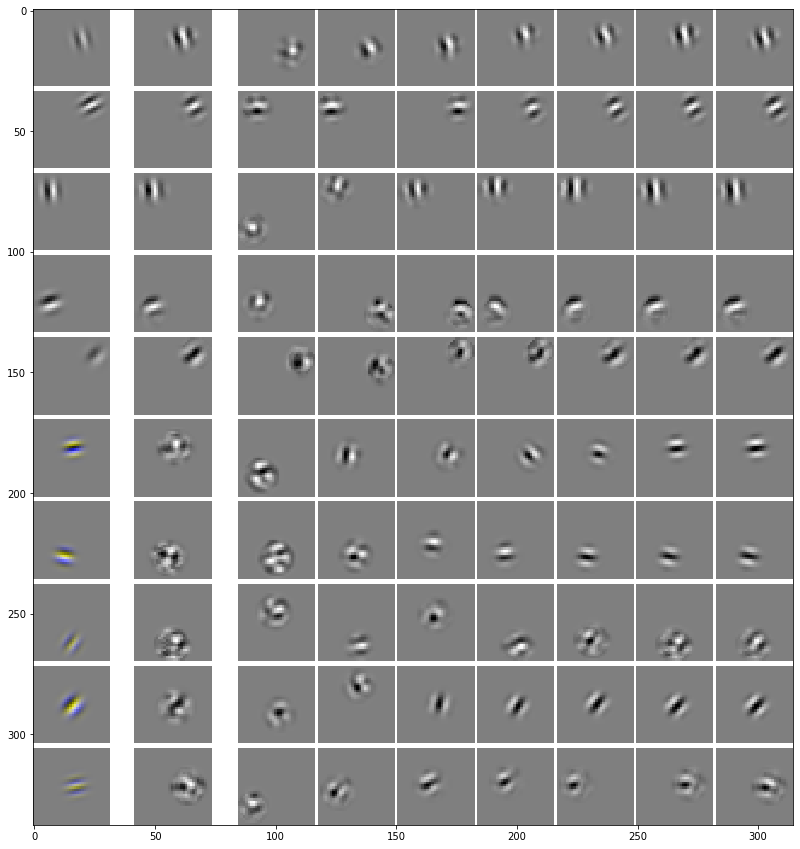

In [7]:
# visualize the ground truth RFs, input gradients and MEIs

def bw(im, normalize=True, edge=True):
    if normalize:
        #im = (im - np.min(im)) / (np.max(im) - np.min(im))
        im = 0.5 + 0.5 * im / np.max(np.abs(im))    
    if edge:
        im = np.concatenate([im, np.ones((im.shape[0], 1))], axis=-1)
    return np.tile(np.expand_dims(im, axis=-1), [1, 1, 3])

def colorize_rf(true_rf, simple_cell):
    first_channel = true_rf
    second_channel = true_rf * simple_cell[:,None,None] + true_rf_ps * ~simple_cell[:,None,None] 
    third_channel = (first_channel + second_channel) / 2

    return 0.5+0.5*np.stack([first_channel, first_channel, second_channel], axis=-1)

rf_norm = np.max(np.abs(np.concatenate([true_rf, true_rf_ps])))
colorized_rfs = colorize_rf(true_rf / rf_norm, simple_cell)
space = np.ones((image_shape[0],10,3))

def summarize_cell(cell=6, edge=True):
    import tensorflow as tf
    
    patches = [colorized_rfs[cell], space, bw(dy_dx[cell]), space]
    patches.extend([bw(x) for x in np.transpose(tf.nn.sigmoid(meis[cell])-0.5, [-1, 0, 1])])

    patches = np.concatenate(patches, axis=1)
    
    if edge:
        patches = np.concatenate([patches, np.ones((2, patches.shape[1], 3))], axis=0)
    
    return patches

simple_list = list(np.where(simple_cell)[0][:5])
complex_list = list(np.where(~simple_cell)[0][:5])

patches = [summarize_cell(i) for i in simple_list + complex_list]
patches = np.concatenate(patches, axis=0)
patches = patches[:-2, :-1, :]
plt.figure(figsize=(20,15))
plt.imshow(patches)

# Excess uncertainty versus observation set size

In [8]:
from tuning_manifold.util import compute_excess

def compute_excess(model, data, iterations=100):
    import tensorflow_probability as tfp
    import numpy as np

    tfpl = tfp.layers
    tfd = tfp.distributions

    ll = []
    true_ll = []

    import itertools
    for data in itertools.islice(data, iterations):
        ll.append(-model(data[0]).log_prob(data[1])[0])

        true_dist = tfpl.DistributionLambda(make_distribution_fn=lambda t: tfd.Poisson(t))(data[0][-1] + 1e-7)
        true_ll.append(negloglik(data[1], true_dist)[0])

    ll = np.concatenate(ll, axis=-1)
    true_ll = np.concatenate(true_ll, axis=-1)

    final_ll = np.mean(np.mean(ll, axis=-1)[-10:])
    true_ll = np.mean(true_ll)
    model_ll = np.mean(ll, -1)  # across neurons

    data = dict({'final_ll': final_ll,
                 'true_ll': true_ll,
                 'excess_ll': final_ll - true_ll,
                 'll_function': model_ll})

    return data

excess = compute_excess(model, validation_data)

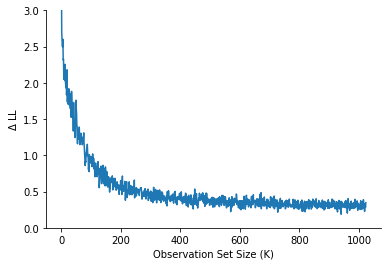

In [9]:
plt.plot(excess['ll_function'] - excess['true_ll'])

plt.ylim(0, 3)
plt.ylabel('$\Delta$ LL')
plt.xlabel('Observation Set Size (K)')
plt.legend(frameon=False)

sns.despine(trim=False)
